In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy
from sklearn import svm
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

import random

In [2]:
X = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/X.npy');
y = np.load('/oasis/projects/nsf/csd395/ruogu/svm2/y.npy');
print "%s" %(X.shape,);
print "%s" %(y.shape,);
raw_data = zip(X, y);
print type(raw_data);
del X;
del y;

(188118, 4200)
(188118,)
<type 'list'>


In [11]:
data = [];
n_classSample = 1000; # Number of samples from each class
for i in range(0, 10):
    data_for_class = [x for x in raw_data if x[1] == i];
    data = data + random.sample(data_for_class, n_classSample);
# data is a list of (ndarray, int)
random.shuffle(data);
quota = 0.75;
n_training = int(len(data) * quota);
n_testing = len(data) - n_training;

In [12]:
training_data = data[:n_training];
testing_data = data[n_training:];

In [13]:
training_X = np.asarray([x[0] for x in training_data]);
training_y = np.asarray([x[1] for x in training_data]);
testing_X = np.asarray([x[0] for x in testing_data]);
testing_y = np.asarray([x[1] for x in testing_data]);

In [14]:
print "Shape of training data: %s" %(training_X.shape,);
print "Shape of training label: %s" %(training_y.shape,);
print "Shape of testing data: %s" %(testing_X.shape,);
print "Shape of testing label: %s" %(testing_y.shape,);

Shape of training data: (7500, 4200)
Shape of training label: (7500,)
Shape of testing data: (2500, 4200)
Shape of testing label: (2500,)


In [15]:
# Train in parallel.
def train_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=8); # This is a compution-heavy work, so we can have more process, like 15.
result = pool.map(train_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 466.546570063 sec.


In [16]:
sorted(result, key=lambda x: x[0]);
myKernel = np.asarray([v[1] for v in result]);
myKernel = myKernel.reshape(n_training, n_training);

In [17]:
# Train SVM
clf = svm.SVC(kernel="precomputed", decision_function_shape='ovr');
clf.fit(myKernel, training_y);

In [18]:
# Training accuracy
predict_labels_train = clf.predict(myKernel);
n_correct_train = 0;
for i in range(len(training_data)):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / len(training_data));

Training accuracy: 0.892266666667


In [19]:
cm_train = confusion_matrix(training_y, predict_labels_train);

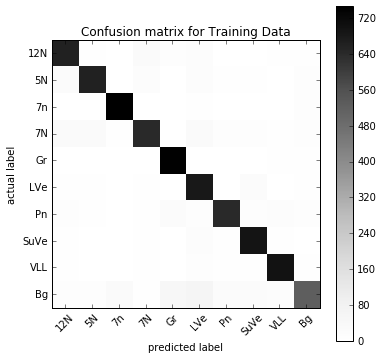

In [20]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Greys);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Training Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);

In [28]:
supp_indices = clf.support_;
supp_vecs = training_X[clf.support_];

In [32]:
# Test in paralle.
def test_job(i):
    xi = testing_X[i];
    vals = 0.5 * np.sum(supp_vecs + xi - np.abs(supp_vecs - xi), axis=1); # Equals to min(xi, xj)
    his = np.zeros(n_training);
    his[supp_indices] = vals;
    return (i, his);

start = time();
pool = Pool(processes=16);
result = pool.map(test_job, range(0, n_testing));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 149.807309866 sec.


In [34]:
sorted(result, key=lambda x: x[0]);
testKernel = np.asarray([v[1] for v in result]);
testKernel = testKernel.reshape(n_testing, n_training);

In [35]:
predict_labels_test = clf.predict(testKernel);
n_correct_test = 0;
for i in range(0, n_testing):
    if (predict_labels_test[i] == testing_y[i]):
        n_correct_test += 1;
print "Test accuracy: {}".format(1.0*n_correct_test / n_testing);

Test accuracy: 0.6052


In [36]:
cm_test = confusion_matrix(testing_y, predict_labels_test);

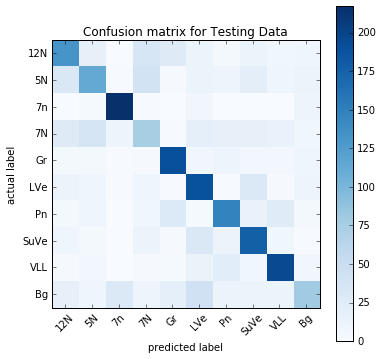

In [37]:
plt.figure(figsize=(6, 6));
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Testing Data');
plt.colorbar();
classes = ['12N', '5N', '7n', '7N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 'Bg'];
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45);
plt.yticks(tick_marks, classes);